# Interactive

We set up some code to generate captions using our method.

In this notebook, we provide the following demonstrations:

1. The way to display a single image.
2. The ability to load in an issue partition.
3. Generate issue-sensitive and non-issue-sensitive partitions

In [1]:
from evaluation import CUBPartitionDataset, BirdDistractorDataset, load_inc_rsa_model

In [2]:
cub_partition = CUBPartitionDataset()
rsa_dataset = BirdDistractorDataset(randomized=True)
rsa_model = load_inc_rsa_model(rsa_dataset)

Arguments:
data_path                     ./data
checkpoint_path               ./checkpoints
log_step                      10
num_workers                   4
disable_cuda                  False
cuda_device                   0
torch_seed                    6424113861887611368
model                         gve
dataset                       cub
pretrained_model              None
layers_to_truncate            1
sc_ckpt                       data/cub/sentence_classifier_ckpt.pth
weights_ckpt                  None
loss_lambda                   0.2
embedding_size                1000
hidden_size                   1000
num_epochs                    50
batch_size                    128
learning_rate                 0.001
train                         False
eval_ckpt                     ./checkpoints/gve-cub-D2020-03-14-T18-04-04-G0-best-ckpt.pth

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
i

### 1. Load in and display a bird image!

In [21]:
from PIL import Image

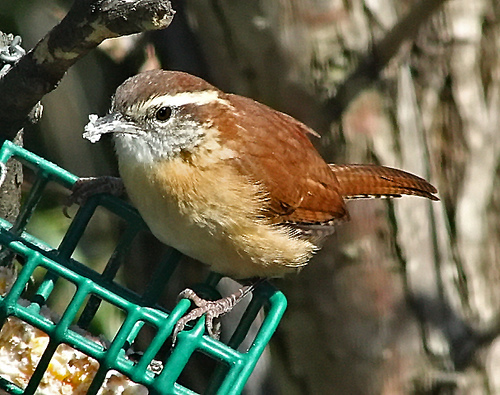

In [4]:
display(Image.open("./data/cub/images/195.Carolina_Wren/Carolina_Wren_0029_186212.jpg"))

### 2. Obtain an image's issue partition

Given a target image that we wish to generate captions, we can obtain an issue partition ("head pattern", "belly color", etc.)

We do this by steps: 

**First**, here are the 17 issues that we can actually generate captions on this dataset.

In [7]:
cub_partition.issue_vocab

['has_wing_pattern',
 'has_belly_pattern',
 'has_breast_pattern',
 'has_nape_color',
 'has_upper_tail_color',
 'has_under_tail_color',
 'has_back_color',
 'has_leg_color',
 'has_throat_color',
 'has_crown_color',
 'has_bill_shape',
 'has_eye_color',
 'has_wing_color',
 'has_bill_color',
 'has_breast_color',
 'has_belly_color',
 'has_bill_length']

**Second**, we see what are the actual issues that can be talked about on this bird -- we obtain the "available" issues by querying the attribute annotations provided by MTurkers in the CUB dataset.

In this example, we want to know what issues we can talk about for the bird above, we send in it's file name (which consists of both the folder and the actual image name): `195.Carolina_Wren/Carolina_Wren_0029_186212.jpg`

In [8]:
cub_partition.get_valid_issues("195.Carolina_Wren/Carolina_Wren_0029_186212.jpg")

([8, 11, 12, 13, 14, 15, 16],
 ['has_throat_color',
  'has_eye_color',
  'has_wing_color',
  'has_bill_color',
  'has_breast_color',
  'has_belly_color',
  'has_bill_length'])

By the look of it, this bird has its throat, eye, wing, bill, breast, belly colors annotated, as well as bill length.

**Third**, after we pick an issue that we are interested in, let's say "throat color", then we find that it's issue id is 8.

We use the `get_cells_by_partition` method to get images that have similar annotations around throat color of the target image (`sim_cell`), and images that do not have annotations about throat color (`dis_cell`).

We can print them out a bit and see what they look like!

In [46]:
bird_img_id = "195.Carolina_Wren/Carolina_Wren_0029_186212.jpg"
dis_cell, sim_cell, _, dis_indices, sim_indices = cub_partition.get_cells_by_partition(bird_img_id, issue_id=16, max_cap_per_cell=40)

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [63]:
from evaluation import plot_images

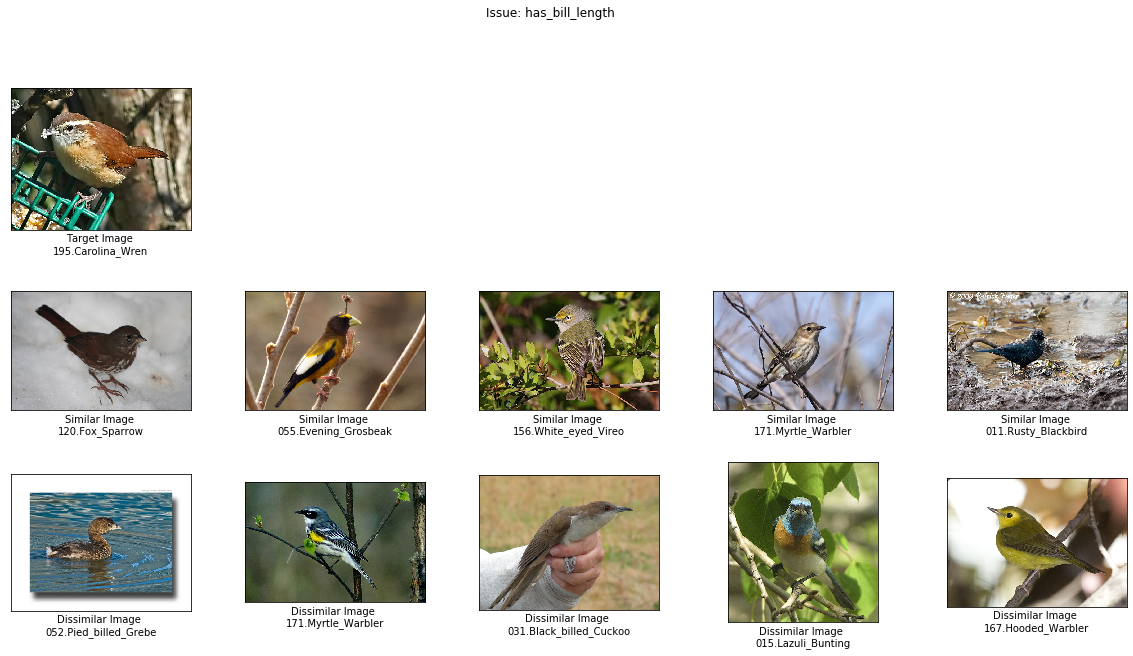

In [64]:
plot_images(bird_img_id, dis_cell, sim_cell, "has_bill_length")

Keep in mind that we don't require similar images to look exactly the same as our target image on the chosen issue -- for example, our target Carolina Wren might have brown/red-ish wings -- the images we put in the "similar" cell can have "blue" wings. This is because we want the caption model to discuss the issue focusing on wing color in general, not a particular wing color.

### 3. Generate issue-sensitive captions

We take the **Carolina Wren image**, and choose issue **bill length**.

We show the 4 models we compared in the paper:

**First**, **S0** model:

Note that it takes nothing except the target image id.

In [74]:
rsa_model.semantic_speaker([bird_img_id])

['this bird has a brown crown a white eyebrow and a brown and white breast']

**Second**, **S1** model, a very typical RSA model that is not issue sensitive.

Note that we are only adding "distractor" images, but not "similar" images. The rationality is kept low because with higher rationality, the caption becomes ungrammatical very quickly.

Also note that the caption is wrong, it says **long beak**, while clearly the target bird has a **small/short beak**.

In [77]:
rsa_model.greedy_pragmatic_speaker_free([bird_img_id] + dis_cell,
                                       num_sim=0, rationality=1,
                                       speaker_prior=True, entropy_penalty_alpha=0)[0]

'a small brown bird with a long beak and long tail feathers'

**Third**, **S1+Q** model, an issue sensitive model without our entropy penalty.

Note that `entropy_penalty_alpha=0`.

This model generated a caption that completely failed to mention anything about the bill length. This is because there are so many other issues it could focus on -- without the entropy pressure, it won't have the added pressure to discuss our chosen issue.

In [79]:
rsa_model.greedy_pragmatic_speaker_free([bird_img_id] + sim_cell + dis_cell,
                                       num_sim=40, rationality=12,
                                       speaker_prior=True, entropy_penalty_alpha=0)[0]

'this bird has a red spotted breast brown crown and white eyebrow'

**Lastly**, **S1+QH** model, our model with entropy pressure.

Now this caption model correctly generates **small bill**.

In [80]:
rsa_model.greedy_pragmatic_speaker_free([bird_img_id] + sim_cell + dis_cell,
                                       num_sim=40, rationality=12,
                                       speaker_prior=True, entropy_penalty_alpha=0.5)[0]

'this bird has a small head a rounded belly and a small bill'

### Now you try!

1. Note that our method does not always work. Sometimes **S1** addresses an issue but, **S1-QH** fails to do so.
2. You can tune the rationality and entropy penalty hyper-parameters and see how they affect the outputted captions!